In [1]:
import tqdm
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F_
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from torch.utils.data import Dataset, DataLoader

fatal: destination path 'CycleGAN' already exists and is not an empty directory.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘/content/gdrive/My Drive/CGAN_results’: File exists


In [0]:
class dataset(Dataset):
    def __init__(self):
        image_size = 256
        self.datasetA = list(torchvision.datasets.ImageFolder(root='/datasets/horse2zebra/horses',
                                                        transform=transforms.Compose([transforms.Resize(image_size),
                                                        transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])))
        self.datasetB = list(torchvision.datasets.ImageFolder(root='/datasets/horse2zebra/zebras',
                                                        transform=transforms.Compose([transforms.Resize(image_size),
                                                        transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])))
        self.max_length = max(len(self.datasetA),len(self.datasetB))
        if self.max_length == len(self.datasetA):
            self.datasetB.extend(random.sample(self.datasetB, len(self.datasetB))
                                 [:self.max_length-len(self.datasetB)])
        elif self.max_length == len(self.datasetB):
            self.datasetA.extend(random.sample(self.datasetA, len(self.datasetA))
                                 [:self.max_length-len(self.datasetA)])
    
    def __len__(self):
        return self.max_length
    
    def __getitem__(self, idx):
        return self.datasetA[idx], self.datasetB[idx]
        

In [0]:
dataloader = DataLoader(dataset(), batch_size=1, shuffle=True, num_workers=1)

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else 'cpu')
print(device)
pool_size = 50

cuda:0


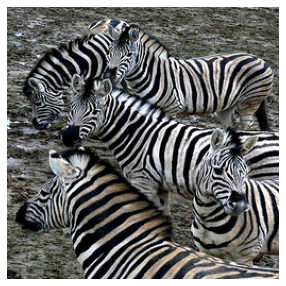

In [5]:
real_batch = next(iter(dataloader))[1]
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
class ResidualBlock(nn.Module):
        def __init__(self, in_c=256, out_c=256, k=3):
            super(ResidualBlock, self).__init__()
            self.model = nn.Sequential(
                nn.ReflectionPad2d(int(k/2)),
                nn.Conv2d(in_c, out_c, kernel_size=k),
                nn.ReLU(True),
                nn.ReflectionPad2d(int(k/2)),
                nn.Conv2d(out_c, out_c, kernel_size=k),
                nn.ReLU(True)
            )
            self.relu = nn.ReLU()
        
        def forward(self, x):
            residual = x
            x = self.model(x)
            return (x+residual)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        temp = [ResidualBlock() for i in range(9)]
        self.residual_block = nn.Sequential(*temp)
        self.model = nn.Sequential(
            self.get_conv_block(3, 64),
            self.get_conv_block(64, 128, k=3, s=2),
            self.get_conv_block(128, 256, k=3, s=2),
            self.residual_block,
            self.get_conv_t_block(256, 128),
            self.get_conv_t_block(128, 64),
            self.get_conv_block(64, 3),
            nn.Tanh()
        )
    
    def get_conv_block(self, in_c, out_c, k=7, s=1):
        return nn.Sequential(
            nn.ReflectionPad2d(int(k/2)),
            nn.Conv2d(in_c, out_c, kernel_size=k, stride=s),
            nn.InstanceNorm2d(in_c),
            nn.ReLU(True),
        )
    
    def get_conv_t_block(self, in_c, out_c, k=3, s=2):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=1, output_padding=1),
            nn.InstanceNorm2d(in_c),
            nn.ReLU(True),
        )
    
    # def normalise(self, X):
    #     batch_size = X.shape[0]
    #     img_size = X.shape[-1]
    #     X = X.view(batch_size, 3, -1)
    #     min_x, max_x = torch.min(X, dim=2)[0].unsqueeze(2), torch.max(X, dim=2)[0].unsqueeze(2)
    #     X = (X-min_x)/(max_x-min_x+1e-8)
    #     X = X.view(batch_size, 3, img_size, -1)
    #     return X

    
    def forward(self, x):
        # return self.normalise(self.model(x))
        return self.model(X)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            self.get_conv_block(3, 64),
            self.get_conv_block(64, 128, norm=nn.InstanceNorm2d(128)),
            self.get_conv_block(128, 256, norm=nn.InstanceNorm2d(256)),
            self.get_conv_block(256, 512, norm=nn.InstanceNorm2d(512)),
            nn.Conv2d(512, 1, 4, 2, 1),
            nn.Sigmoid()
        )
    
    def get_conv_block(self, in_c, out_c, k=4, s=2, p=1,  norm=nn.Identity()):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, k, s, p),
            norm,
            nn.LeakyReLU(True, 0.2)
        )
        
    
    def forward(self, x):
        return self.model(x)

In [0]:
def weights_init(m) :
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [0]:
lr = 0.0002
num_epochs = 100
def get_generator(lr=lr, b1=0.5, b2=0.999):
    model = Generator().to(device)
    model.apply(weights_init)
    opt = optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))
    return model, opt

def get_discriminator(lr=lr, b1=0.5, b2=0.999):
    model = Discriminator().to(device)
    model.apply(weights_init)
    opt = optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))
    return model, opt

In [0]:
#F: X->Y
F, optF = get_generator()
#G: Y->X
G, optG = get_generator()
#D_X: verifies X
D_X, optX = get_discriminator()
#D_Y: verifies Y
D_Y, optY = get_discriminator()

In [0]:
GANLoss = nn.MSELoss()

def get_loss(model, X, label):
    output = model(X)
    output = output.view(X.shape[0],-1).mean(1, keepdims=True).squeeze(1)
    Y = torch.full((output.shape[0], ),label, device=device, dtype=torch.float).detach()
    loss = GANLoss(output, Y)
    return loss

def get_cycle_loss(X, Y):
    loss = torch.abs(X-Y).mean()
    accuracy = (torch.abs(X-Y)<0.002).float().mean()
    return loss, accuracy
  
def get_fake(image, fake_pool) :
    if len(fake_pool) < pool_size :
        fake_pool.append(image.cpu())
        return image
    else :
        p = random.random()
        if p > 0.5:
            random_id = random.randint(0,pool_size-1)
            temp = fake_pool[random_id]
            fake_pool[random_id] = image.cpu()
            return temp
        else :
            return image

In [0]:
def show_images(images):
    plt.figure(figsize=(5,5))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(images.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
lambda_ = lambda x : x - (lr/num_epochs)
schedulerF = optim.lr_scheduler.LambdaLR(optF, lr_lambda=lambda_)
schedulerG = optim.lr_scheduler.LambdaLR(optG, lr_lambda=lambda_)
schedulerY = optim.lr_scheduler.LambdaLR(optY, lr_lambda=lambda_)
schedulerX = optim.lr_scheduler.LambdaLR(optX, lr_lambda=lambda_)
G_losses = []
F_losses = []
accuracies = []

In [0]:
fake_pool_X = []
fake_pool_Y = []
X, Y   = None, None
X_, Y_ = None, None
F.train()
G.train()
D_X.train()
D_Y.train()
for epoch in tqdm.trange(num_epochs*2) :
    show=True
    for i, (X, Y) in enumerate(dataloader) :
        optX.zero_grad()
        optY.zero_grad()
        optF.zero_grad()
        optG.zero_grad()
        
        X = torch.FloatTensor(X[0]).to(device) #real X
        Y = torch.FloatTensor(Y[0]).to(device) #real Y
        
        Y_ = F(X)  #fake Y
        X_ = G(Y)  #fake X
        
        rec_X = G(Y_)
        rec_Y = F(X_)
        
        errD_X = get_loss(D_X, X, 1)+get_loss(D_X, get_fake(X_, fake_pool_X).detach().to(device), 0)
        errD_Y = get_loss(D_Y, Y, 1)+get_loss(D_Y, get_fake(Y_, fake_pool_Y).detach().to(device), 0)
        
        D_loss = (errD_X+errD_Y)*0.5
        
        D_loss.backward()
        optX.step()
        optY.step()
        
        errF = get_loss(D_Y, Y_, 0)
        errG = get_loss(D_X, X_, 0)
        cycle_lossX, accuracyX = get_cycle_loss(X, rec_X)
        cycle_lossY, accuracyY = get_cycle_loss(Y, rec_Y)
        cycle_loss = cycle_lossX+cycle_lossY
        accuracy = (accuracyX+accuracyY)/2.0                 
        identity_lossX, _ = get_cycle_loss(X, G(X))
        identity_lossY, _ = get_cycle_loss(Y, F(Y))
        
        G_loss = errF+errG+10*(cycle_lossX+cycle_lossY)+(identity_lossX+identity_lossY)
        
        G_loss.backward()
        optF.step()
        optG.step()
                
        F_losses.append((errF, errD_Y))
        G_losses.append((errG, errD_X))
        accuracies.append(accuracy)
        if i%500==0 :
            print("--------------------------")
            print("Epoch: {} Batch: {} \nerrF = {} \nerrDY = {} \nerrG = {} \nerrDX = {}\nCycleLoss = {}\nper_pix_acc = {}".format(epoch, i, errF,errD_Y,errG,errD_Y,cycle_loss, accuracy))
            print("--------------------------")
        if show:
            show_images(X)
            show_images(Y_.detach())
            show=False

    if epoch%20==0:
        path = './results/{}/'.format(epoch)
        os.mkdir(path)
        torch.save({
            'F':F.state_dict(),
            'G':G.state_dict(),
            'D_X':D_X.state_dict(),
            'D_Y':D_Y.state_dict(),
            },path+"model.pt")
        save_image(X.squeeze() , path+"X.png")
        save_image(Y.squeeze() , path+"Y.png")
        save_image(X_.squeeze(), path+"X_.png")
        save_image(Y_.squeeze(), path+"Y_.png")
    if epoch>=100:
        schedulerX.step()
        schedulerY.step()
        schedulerF.step()
        schedulerG.step()

  0%|          | 0/200 [00:00<?, ?it/s]

--------------------------
Epoch: 0 Batch: 0 
errF = 0.16098645329475403 
errDY = 0.4273531138896942 
errG = 0.30362358689308167 
errDX = 0.4273531138896942
CycleLoss = 0.9670243263244629
per_pix_acc = 0.00099945068359375
--------------------------
--------------------------
Epoch: 0 Batch: 500 
errF = 0.24842843413352966 
errDY = 0.4811502695083618 
errG = 0.2788611054420471 
errDX = 0.4811502695083618
CycleLoss = 0.9221736192703247
per_pix_acc = 0.0014216105919331312
--------------------------
--------------------------
Epoch: 0 Batch: 1000 
errF = 0.2139519304037094 
errDY = 0.438335120677948 
errG = 0.24751073122024536 
errDX = 0.438335120677948
CycleLoss = 1.144528865814209
per_pix_acc = 0.00078582763671875
--------------------------
mkdir: cannot create directory ‘/content/gdrive/My Drive/CGAN_results/0’: File exists


  0%|          | 1/200 [08:16<27:27:24, 496.71s/it]

--------------------------
Epoch: 1 Batch: 0 
errF = 0.2155529111623764 
errDY = 0.5492419600486755 
errG = 0.2794118821620941 
errDX = 0.5492419600486755
CycleLoss = 0.9327516555786133
per_pix_acc = 0.0012690227013081312
--------------------------
--------------------------
Epoch: 1 Batch: 500 
errF = 0.2040308713912964 
errDY = 0.4757554531097412 
errG = 0.2785317897796631 
errDX = 0.4757554531097412
CycleLoss = 1.012030839920044
per_pix_acc = 0.0007960001821629703
--------------------------
--------------------------
Epoch: 1 Batch: 1000 
errF = 0.1979215145111084 
errDY = 0.471751868724823 
errG = 0.2685558795928955 
errDX = 0.471751868724823
CycleLoss = 1.0124056339263916
per_pix_acc = 0.00079345703125
--------------------------


  1%|          | 2/200 [16:29<27:15:27, 495.59s/it]

--------------------------
Epoch: 2 Batch: 0 
errF = 0.19254931807518005 
errDY = 0.48404908180236816 
errG = 0.2717817425727844 
errDX = 0.48404908180236816
CycleLoss = 1.050485610961914
per_pix_acc = 0.0008646647329442203
--------------------------
--------------------------
Epoch: 2 Batch: 500 
errF = 0.24082203209400177 
errDY = 0.47562339901924133 
errG = 0.27752500772476196 
errDX = 0.47562339901924133
CycleLoss = 1.2917070388793945
per_pix_acc = 0.0010706584434956312
--------------------------
--------------------------
Epoch: 2 Batch: 1000 
errF = 0.1558045744895935 
errDY = 0.43331894278526306 
errG = 0.3007966876029968 
errDX = 0.43331894278526306
CycleLoss = 1.197624921798706
per_pix_acc = 0.0007044474477879703
--------------------------


  2%|▏         | 3/200 [24:42<27:04:23, 494.74s/it]

--------------------------
Epoch: 3 Batch: 0 
errF = 0.2086275964975357 
errDY = 0.41446587443351746 
errG = 0.26882243156433105 
errDX = 0.41446587443351746
CycleLoss = 1.0147836208343506
per_pix_acc = 0.0011876424541696906
--------------------------
--------------------------
Epoch: 3 Batch: 500 
errF = 0.2392706274986267 
errDY = 0.4651387333869934 
errG = 0.29581236839294434 
errDX = 0.4651387333869934
CycleLoss = 1.2589747905731201
per_pix_acc = 0.00048065188457258046
--------------------------
--------------------------
Epoch: 3 Batch: 1000 
errF = 0.22441279888153076 
errDY = 0.5258544087409973 
errG = 0.31538012623786926 
errDX = 0.5258544087409973
CycleLoss = 1.2687339782714844
per_pix_acc = 0.0003916422720067203
--------------------------


  2%|▏         | 4/200 [32:55<26:54:13, 494.15s/it]

--------------------------
Epoch: 4 Batch: 0 
errF = 0.24832303822040558 
errDY = 0.46254485845565796 
errG = 0.32250019907951355 
errDX = 0.46254485845565796
CycleLoss = 1.0499460697174072
per_pix_acc = 0.0007171630859375
--------------------------
--------------------------
Epoch: 4 Batch: 500 
errF = 0.19115513563156128 
errDY = 0.43202757835388184 
errG = 0.2633800506591797 
errDX = 0.43202757835388184
CycleLoss = 1.4054784774780273
per_pix_acc = 0.0008977254619821906
--------------------------
--------------------------
Epoch: 4 Batch: 1000 
errF = 0.23004144430160522 
errDY = 0.4410492181777954 
errG = 0.2960702180862427 
errDX = 0.4410492181777954
CycleLoss = 0.9391666054725647
per_pix_acc = 0.0011088054161518812
--------------------------


  2%|▎         | 5/200 [41:07<26:44:37, 493.73s/it]

--------------------------
Epoch: 5 Batch: 0 
errF = 0.24068568646907806 
errDY = 0.473998486995697 
errG = 0.21633696556091309 
errDX = 0.473998486995697
CycleLoss = 1.1228232383728027
per_pix_acc = 0.00061798095703125
--------------------------
--------------------------
Epoch: 5 Batch: 500 
errF = 0.19863182306289673 
errDY = 0.4869686961174011 
errG = 0.21775805950164795 
errDX = 0.4869686961174011
CycleLoss = 1.3212378025054932
per_pix_acc = 0.0007654826040379703
--------------------------
--------------------------
Epoch: 5 Batch: 1000 
errF = 0.19057607650756836 
errDY = 0.4795539975166321 
errG = 0.2742442786693573 
errDX = 0.4795539975166321
CycleLoss = 0.8728411197662354
per_pix_acc = 0.0006001790752634406
--------------------------


  3%|▎         | 6/200 [49:20<26:35:27, 493.44s/it]

--------------------------
Epoch: 6 Batch: 0 
errF = 0.166554793715477 
errDY = 0.47122448682785034 
errG = 0.24180932343006134 
errDX = 0.47122448682785034
CycleLoss = 0.9162788987159729
per_pix_acc = 0.0008748372783884406
--------------------------
--------------------------
Epoch: 6 Batch: 500 
errF = 0.21517613530158997 
errDY = 0.4788205623626709 
errG = 0.2545297145843506 
errDX = 0.4788205623626709
CycleLoss = 1.2258481979370117
per_pix_acc = 0.0006891886587254703
--------------------------
--------------------------
Epoch: 6 Batch: 1000 
errF = 0.21500591933727264 
errDY = 0.46464723348617554 
errG = 0.26583436131477356 
errDX = 0.46464723348617554
CycleLoss = 1.0308969020843506
per_pix_acc = 0.0007197062368504703
--------------------------


  4%|▎         | 7/200 [57:33<26:26:25, 493.19s/it]

--------------------------
Epoch: 7 Batch: 0 
errF = 0.24788732826709747 
errDY = 0.4835928976535797 
errG = 0.2588863968849182 
errDX = 0.4835928976535797
CycleLoss = 1.3750243186950684
per_pix_acc = 0.0007680257549509406
--------------------------
--------------------------
Epoch: 7 Batch: 500 
errF = 0.22598475217819214 
errDY = 0.4393700957298279 
errG = 0.2760260999202728 
errDX = 0.4393700957298279
CycleLoss = 0.969075083732605
per_pix_acc = 0.0011164348106831312
--------------------------
--------------------------
Epoch: 7 Batch: 1000 
errF = 0.24058867990970612 
errDY = 0.48424339294433594 
errG = 0.26397705078125 
errDX = 0.48424339294433594
CycleLoss = 0.9840524196624756
per_pix_acc = 0.0009002685546875
--------------------------


  4%|▍         | 8/200 [1:05:46<26:17:47, 493.06s/it]

--------------------------
Epoch: 8 Batch: 0 
errF = 0.18857896327972412 
errDY = 0.4023965001106262 
errG = 0.24630627036094666 
errDX = 0.4023965001106262
CycleLoss = 1.198803186416626
per_pix_acc = 0.0009180704946629703
--------------------------
--------------------------
Epoch: 8 Batch: 500 
errF = 0.21318458020687103 
errDY = 0.4745793342590332 
errG = 0.2658598721027374 
errDX = 0.4745793342590332
CycleLoss = 1.1053873300552368
per_pix_acc = 0.0008188883657567203
--------------------------
--------------------------
Epoch: 8 Batch: 1000 
errF = 0.22521910071372986 
errDY = 0.5088320970535278 
errG = 0.2631225287914276 
errDX = 0.5088320970535278
CycleLoss = 1.1957428455352783
per_pix_acc = 0.0007781982421875
--------------------------


  4%|▍         | 9/200 [1:13:58<26:09:18, 492.98s/it]

--------------------------
Epoch: 9 Batch: 0 
errF = 0.2625431716442108 
errDY = 0.48647916316986084 
errG = 0.2449900209903717 
errDX = 0.48647916316986084
CycleLoss = 1.219010353088379
per_pix_acc = 0.001007080078125
--------------------------
--------------------------
Epoch: 9 Batch: 500 
errF = 0.24338677525520325 
errDY = 0.5020398497581482 
errG = 0.23621323704719543 
errDX = 0.5020398497581482
CycleLoss = 0.9978853464126587
per_pix_acc = 0.00099945068359375
--------------------------
--------------------------
Epoch: 9 Batch: 1000 
errF = 0.20196743309497833 
errDY = 0.49107468128204346 
errG = 0.2963303327560425 
errDX = 0.49107468128204346
CycleLoss = 1.1651151180267334
per_pix_acc = 0.0007502238149754703
--------------------------


  5%|▌         | 10/200 [1:22:11<26:00:53, 492.91s/it]

--------------------------
Epoch: 10 Batch: 0 
errF = 0.1762022227048874 
errDY = 0.42191389203071594 
errG = 0.2576543688774109 
errDX = 0.42191389203071594
CycleLoss = 1.077681064605713
per_pix_acc = 0.0008112589712254703
--------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


--------------------------
Epoch: 10 Batch: 500 
errF = 0.2340499758720398 
errDY = 0.5375373959541321 
errG = 0.23779642581939697 
errDX = 0.5375373959541321
CycleLoss = 1.0777778625488281
per_pix_acc = 0.0011164348106831312
--------------------------
--------------------------
Epoch: 10 Batch: 1000 
errF = 0.1738383173942566 
errDY = 0.4079754948616028 
errG = 0.33180466294288635 
errDX = 0.4079754948616028
CycleLoss = 1.0150535106658936
per_pix_acc = 0.00110626220703125
--------------------------


  6%|▌         | 11/200 [1:30:24<25:52:40, 492.91s/it]

--------------------------
Epoch: 11 Batch: 0 
errF = 0.20357458293437958 
errDY = 0.4758410155773163 
errG = 0.30974912643432617 
errDX = 0.4758410155773163
CycleLoss = 1.0403773784637451
per_pix_acc = 0.0008722941274754703
--------------------------
--------------------------
Epoch: 11 Batch: 500 
errF = 0.21155577898025513 
errDY = 0.4334592819213867 
errG = 0.26912564039230347 
errDX = 0.4334592819213867
CycleLoss = 0.9861106872558594
per_pix_acc = 0.0011164348106831312
--------------------------
--------------------------
Epoch: 11 Batch: 1000 
errF = 0.24151216447353363 
errDY = 0.5062562227249146 
errG = 0.29344308376312256 
errDX = 0.5062562227249146
CycleLoss = 1.5611631870269775
per_pix_acc = 0.00037384033203125
--------------------------


  6%|▌         | 12/200 [1:38:37<25:44:26, 492.91s/it]

--------------------------
Epoch: 12 Batch: 0 
errF = 0.1970241814851761 
errDY = 0.47706541419029236 
errG = 0.245327427983284 
errDX = 0.47706541419029236
CycleLoss = 1.1826295852661133
per_pix_acc = 0.0007222493295557797
--------------------------
--------------------------
Epoch: 12 Batch: 500 
errF = 0.23044531047344208 
errDY = 0.47150152921676636 
errG = 0.24479298293590546 
errDX = 0.47150152921676636
CycleLoss = 1.107210636138916
per_pix_acc = 0.00081634521484375
--------------------------
--------------------------
Epoch: 12 Batch: 1000 
errF = 0.191635400056839 
errDY = 0.4975070655345917 
errG = 0.26092517375946045 
errDX = 0.4975070655345917
CycleLoss = 1.3194429874420166
per_pix_acc = 0.0007654826040379703
--------------------------


  6%|▋         | 13/200 [1:46:50<25:36:18, 492.93s/it]

--------------------------
Epoch: 13 Batch: 0 
errF = 0.2408308982849121 
errDY = 0.43669596314430237 
errG = 0.21620596945285797 
errDX = 0.43669596314430237
CycleLoss = 1.0848640203475952
per_pix_acc = 0.0009816488018259406
--------------------------
--------------------------
Epoch: 13 Batch: 500 
errF = 0.25673556327819824 
errDY = 0.5016146898269653 
errG = 0.3228818476200104 
errDX = 0.5016146898269653
CycleLoss = 1.0812453031539917
per_pix_acc = 0.0008722941274754703
--------------------------
--------------------------
Epoch: 13 Batch: 1000 
errF = 0.2649657726287842 
errDY = 0.5647655725479126 
errG = 0.28525853157043457 
errDX = 0.5647655725479126
CycleLoss = 1.5549654960632324
per_pix_acc = 0.0007273356313817203
--------------------------


  7%|▋         | 14/200 [1:55:03<25:28:06, 492.94s/it]

--------------------------
Epoch: 14 Batch: 0 
errF = 0.20815987884998322 
errDY = 0.4821813702583313 
errG = 0.2575080394744873 
errDX = 0.4821813702583313
CycleLoss = 1.1885685920715332
per_pix_acc = 0.0008977254619821906
--------------------------
--------------------------
Epoch: 14 Batch: 500 
errF = 0.18515603244304657 
errDY = 0.4169148802757263 
errG = 0.23112772405147552 
errDX = 0.4169148802757263
CycleLoss = 0.8893778920173645
per_pix_acc = 0.0011876424541696906
--------------------------
--------------------------
Epoch: 14 Batch: 1000 
errF = 0.21252185106277466 
errDY = 0.5352138876914978 
errG = 0.24584786593914032 
errDX = 0.5352138876914978
CycleLoss = 1.3760502338409424
per_pix_acc = 0.0006561279296875
--------------------------


  8%|▊         | 15/200 [2:03:16<25:19:53, 492.94s/it]

--------------------------
Epoch: 15 Batch: 0 
errF = 0.2305692732334137 
errDY = 0.48215484619140625 
errG = 0.24536001682281494 
errDX = 0.48215484619140625
CycleLoss = 1.10817289352417
per_pix_acc = 0.00078582763671875
--------------------------
--------------------------
Epoch: 15 Batch: 500 
errF = 0.21388903260231018 
errDY = 0.5230485200881958 
errG = 0.26087549328804016 
errDX = 0.5230485200881958
CycleLoss = 1.0277515649795532
per_pix_acc = 0.0006332398043014109
--------------------------
--------------------------
Epoch: 15 Batch: 1000 
errF = 0.2000952959060669 
errDY = 0.4513345956802368 
errG = 0.27043431997299194 
errDX = 0.4513345956802368
CycleLoss = 1.1884797811508179
per_pix_acc = 0.0008138021221384406
--------------------------


  8%|▊         | 16/200 [2:11:29<25:11:33, 492.90s/it]

--------------------------
Epoch: 16 Batch: 0 
errF = 0.21546964347362518 
errDY = 0.4860180914402008 
errG = 0.24145665764808655 
errDX = 0.4860180914402008
CycleLoss = 0.9702883958816528
per_pix_acc = 0.0008519490947946906
--------------------------
--------------------------
Epoch: 16 Batch: 500 
errF = 0.1988259255886078 
errDY = 0.4605461359024048 
errG = 0.23903027176856995 
errDX = 0.4605461359024048
CycleLoss = 0.9275844097137451
per_pix_acc = 0.0013605754356831312
--------------------------
--------------------------
Epoch: 16 Batch: 1000 
errF = 0.19864800572395325 
errDY = 0.42713314294815063 
errG = 0.3057595193386078 
errDX = 0.42713314294815063
CycleLoss = 1.077078938484192
per_pix_acc = 0.001007080078125
--------------------------


  8%|▊         | 17/200 [2:19:42<25:03:53, 493.08s/it]

--------------------------
Epoch: 17 Batch: 0 
errF = 0.2199087142944336 
errDY = 0.44309180974960327 
errG = 0.28951480984687805 
errDX = 0.44309180974960327
CycleLoss = 0.9768339395523071
per_pix_acc = 0.0009943644981831312
--------------------------
--------------------------
Epoch: 17 Batch: 500 
errF = 0.23388004302978516 
errDY = 0.4590797424316406 
errG = 0.26128649711608887 
errDX = 0.4590797424316406
CycleLoss = 0.9947875738143921
per_pix_acc = 0.0008519490947946906
--------------------------
--------------------------
Epoch: 17 Batch: 1000 
errF = 0.24472132325172424 
errDY = 0.5169668197631836 
errG = 0.23640181124210358 
errDX = 0.5169668197631836
CycleLoss = 1.4456493854522705
per_pix_acc = 0.0004933675518259406
--------------------------


  9%|▉         | 18/200 [2:27:55<24:55:48, 493.12s/it]

--------------------------
Epoch: 18 Batch: 0 
errF = 0.18782487511634827 
errDY = 0.44755417108535767 
errG = 0.24469971656799316 
errDX = 0.44755417108535767
CycleLoss = 1.0130703449249268
per_pix_acc = 0.0005976359243504703
--------------------------
--------------------------
Epoch: 18 Batch: 500 
errF = 0.1815665364265442 
errDY = 0.41690486669540405 
errG = 0.2679893672466278 
errDX = 0.41690486669540405
CycleLoss = 1.113416075706482
per_pix_acc = 0.00095367431640625
--------------------------
--------------------------
Epoch: 18 Batch: 1000 
errF = 0.19352100789546967 
errDY = 0.43976694345474243 
errG = 0.2896863520145416 
errDX = 0.43976694345474243
CycleLoss = 1.1910042762756348
per_pix_acc = 0.0007044474477879703
--------------------------


 10%|▉         | 19/200 [2:36:09<24:47:42, 493.16s/it]

--------------------------
Epoch: 19 Batch: 0 
errF = 0.19859322905540466 
errDY = 0.40551838278770447 
errG = 0.19979327917099 
errDX = 0.40551838278770447
CycleLoss = 1.1329967975616455
per_pix_acc = 0.0006103515625
--------------------------
--------------------------
Epoch: 19 Batch: 500 
errF = 0.21887999773025513 
errDY = 0.4283226728439331 
errG = 0.27656039595603943 
errDX = 0.4283226728439331
CycleLoss = 1.0739293098449707
per_pix_acc = 0.00080108642578125
--------------------------
--------------------------
Epoch: 19 Batch: 1000 
errF = 0.2332809716463089 
errDY = 0.49051180481910706 
errG = 0.27888837456703186 
errDX = 0.49051180481910706
CycleLoss = 1.3427248001098633
per_pix_acc = 0.0006917318096384406
--------------------------


 10%|█         | 20/200 [2:44:22<24:40:06, 493.37s/it]

--------------------------
Epoch: 20 Batch: 0 
errF = 0.20755082368850708 
errDY = 0.47907206416130066 
errG = 0.27866485714912415 
errDX = 0.47907206416130066
CycleLoss = 1.2421823740005493
per_pix_acc = 0.0004526774282567203
--------------------------
--------------------------
Epoch: 20 Batch: 500 
errF = 0.1833113431930542 
errDY = 0.42305052280426025 
errG = 0.2669638991355896 
errDX = 0.42305052280426025
CycleLoss = 0.9729948043823242
per_pix_acc = 0.0008824666729196906
--------------------------


In [0]:
plt.figure(figsize=(10,5))
plt.title("X -> Y : Generator and Discriminator Loss During Training")
plt.plot([i[0] for i in G_losses],label="G")
plt.plot([i[1] for i in G_losses],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
plt.figure(figsize=(10,5))
plt.title("Y->X : Generator and Discriminator Loss During Training")
plt.plot([i[0] for i in G_losses],label="G")
plt.plot([i[1] for i in G_losses],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
F.eval()
G.eval()
D_X.eval()
D_Y.eval()
horses, zebras = next(iter(dataloader))
horses, zebras = horses[0].to(device), zebras[0].to(device)
fake_horses, fake_zebras = F(horses), G(zebras)
horses, zebras = horses.cpu(), zebras.cpu()
fake_horses, fake_zebras = fake_horses.detach().cpu(),fake_zebras.detach().cpu()

In [0]:
show_images(horses)
show_images(fake_horses)
show_images(zebras)
show_images(fake_zebras)